# [Sentiment Analysis] Sung Si-kyung vs. Jang Beom-june

(Korean title: [Sentiment Analysis] 감성분석을 활용하여 알아보는 성시경 vs.장범준 논란의 '주관적인' 승자는?)

* On a South Korean website, there was a heated discussion on the topic 'Which one of Sung Si-kyung or Jang Beom-june is a greater artist than the other?'. Below are ones of their most hit songs.
    * Sung Si-kyung: "On the road" https://youtu.be/v_K4tnMYsn4?t=54
    * Jang Beom-june: "Cherry blossom ending" https://www.youtube.com/watch?v=tbJX9f2MYPs
* Obviously, there is no way to objectively decide who is better because it's really a matter of personal musical preference.
    * Personally, I'm a fan of Sung :)
* In this notebook, we try to determine which one of the two artists the users of the website prefer 'subjectively' using the sentiment analysis.
   * **This analysis is for fun only!.** 
   * The result of this analysis should not be used as the evidence for decisively picking the winner.
* This notebook proceeds as follows:
    * Data preprocessing
    * Sentiment analysis (by **Naver's CLOVA Sentiment API**)
        * https://www.ncloud.com/product/aiService/clovaSentiment

        * Result: Jang Beom-june is favoured over Sung Si-kyung on this particular website. 
        
    * Word clouds

* **Again, this analysis is purely for entertainment purposes only!** 

    * They are both great artists loved by a lot of Korean people.
    
I hope you enjoy this notebook!

## 1. Data preprocessing

* Load the raw data 
* Extract comments that mention any of the keywords of the artists.
* Leave only one comment for each ID.
* Split the extracted data by each artist using the keywords.


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/personal/Sentiment-Analyses/Sung_Si-kyung-vs-Jang_Beom-june/")
from A11_init_ import * # contains CLOVA id, secret key, url

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1 a). Load comments data.
* 4,136 comments in total.

In [ ]:
## Load data
comments_df = pd.read_csv("./outputs/A10_comments_raw.csv")
display(comments_df.head(5))
print(comments_df.shape)

,ID,comment
0,구름위로,그놈의 vs질 참 지겹다왕석현100명vs뱅갈호랑이1마리
1,민나상고멘,구름위로 이건 석현이 의견도 들어봐야..
2,괴해신살권,구름위로 김성찬150명 vs 왕석현100명
3,비정상인,2000년생 이상 급식은 장범준90년대생이하는 성시경 나올듯
4,래드키,비정상인 반대임ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ00년생은 성시경 80년생은 장범준인 분위기였음ㅋㅋ...


(4136, 2)


### 1 b) Extract comments that contain at least one of the keywords for both artists.

* Remove random comments that are not related to the artists.
* The keywords consists of the artists' name, nickname, and names of their top hit songs.
    * Sung's keywords = ["시경", "성식", "거리에서", "두사람", "희재"]
    * Jang's keywords = ["범준", "버스커", "벚꽃", "여수", "노래방에서"] 

In [ ]:
sung_keywords = ["시경", "성식", "거리에서", "두사람", "희재"] 
jang_keywords = ["범준", "버스커", "벚꽃", "여수", "노래방에서"]
sung_jang_keywords = sung_keywords + jang_keywords

comments_df2 = pd.DataFrame(columns = ["ID", "comments"])
comments_excluded = pd.DataFrame(columns = ["ID", "comments"])

for idx_c in range(0, len(comments_df)):

    temp_id, temp_comment = comments_df.iloc[idx_c]

    if any(keyword in temp_comment for keyword in sung_jang_keywords) == True:
        comments_df2.loc[len(comments_df2)] = [temp_id, temp_comment]
    else:
        comments_excluded.loc[len(comments_excluded)] = [temp_id, temp_comment]
comments_df2.to_csv("./outputs/A11_comments_extract.csv", index = False)
display(comments_df2.head(5))
print(comments_df2.shape)

,ID,comments
0,비정상인,2000년생 이상 급식은 장범준90년대생이하는 성시경 나올듯
1,래드키,비정상인 반대임ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ00년생은 성시경 80년생은 장범준인 분위기였음ㅋㅋ...
2,비정상인,래드키 앵? 성시경 전성기를 모르는 애들이?
3,BEST 래드키,비정상인 성시경 전성기를 모르니까 풍문으로 들은 애들이 더 고평가엠팍은 나이대가 높...
4,델카이저,래드키 이말이맞음 성시경이 00년대 goat 은 아니자너


(2174, 2)


### 1 c) Remove multiple comments left by each ID. 

* Making sure everyone gets one vote.

In [ ]:
comments_noDups = comments_df2.drop_duplicates(subset = "ID", keep = "first").reset_index(drop = True)
comments_noDups.to_csv("./outputs/A12_comments_noDups.csv", index = False)
display(comments_noDups.head(5))
comments_noDups.shape # Extracts 733 entries.

,ID,comments
0,비정상인,2000년생 이상 급식은 장범준90년대생이하는 성시경 나올듯
1,래드키,비정상인 반대임ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ00년생은 성시경 80년생은 장범준인 분위기였음ㅋㅋ...
2,BEST 래드키,비정상인 성시경 전성기를 모르니까 풍문으로 들은 애들이 더 고평가엠팍은 나이대가 높...
3,델카이저,래드키 이말이맞음 성시경이 00년대 goat 은 아니자너
4,원베일리,"델카이저 근데 장범준이 20년대 goat도 아니잖아 ;가창력은 성시경이 우위고,히트..."


(733, 2)

### 1 d) Split the data by each artist using the keywords.

In [ ]:
## Split sung's and jang's dfs using keywords for each artists.
## Keywords incldue: name, nickname, titles of top hit songs.

comments_noDups = pd.read_csv("./outputs/A12_comments_noDups.csv")

c_data = comments_noDups

sung_df = pd.DataFrame(columns = ["ID", "comments"])     # comments mentioning keywords of Sung
jang_df = pd.DataFrame(columns = ["ID", "comments"])     # comments mentioning keywords of Jang
neutral_df = pd.DataFrame(columns = ["ID", "comments"])  # comments mentioning keywords of both artists

for idx_c in range(0, len(c_data)):
    
    '''
    Each DF contains sentences that include any keyword for one artist, but no keyword for the other.
    If keywords from neither of the artists were included, then the sentence is stored in neutral_df.
    '''

    temp_id, temp_comment = c_data.iloc[idx_c]
    
    if any(sk in temp_comment for sk in sung_keywords) == True and any(jk in temp_comment for jk in jang_keywords) == False:
        sung_df.loc[len(sung_df)] = [temp_id, temp_comment]
    elif any(jk in temp_comment for jk in jang_keywords) == True and any(sk in temp_comment for sk in sung_keywords) == False:
        jang_df.loc[len(jang_df)] = [temp_id, temp_comment]
    else:
        neutral_df.loc[len(neutral_df)] = [temp_id, temp_comment]

## save dfs
sung_df.to_csv("./outputs/B12_sung_df.csv", index = False)
jang_df.to_csv("./outputs/B12_jang_df.csv", index = False)
neutral_df.to_csv("./outputs/B12_neutral_df.csv", index = False)

print("Data for Sung:")
display(sung_df.head(5))
print(sung_df.shape)

print("Data for Jang:")
display(jang_df.head(5))
print(jang_df.shape)

Data for Sung:


,ID,comments
0,델카이저,래드키 이말이맞음 성시경이 00년대 goat 은 아니자너
1,클라우드22,래드키 니가 맞음. 성시경은 고트급인 발라더들은 거론할 것도 없고 김종국도 못이김.
2,Kaka#22.,비정상인 성시경이 요즘 유투브로 잘나가서 근데 이건 비교할거리도 안될정도로 성시경 ...
3,BEST 에펨트리,비정상인 전성기를 모르니깐 대충 들은 이야기 + 예능등에서 본 이미지로 가수를 평가...
4,[Felix],가수로보면 당연히 성시경이지 않나 ㅋㅋ 체급차이 많이나는거 같은데.. 틀이라 그...


(215, 2)
Data for Jang:


,ID,comments
0,난그런거몰라,원베일리 상업성 고려하면 장범준이 맞겠네.
1,ㅈㅅㅎ,원베일리 장범준은 20년대가 아니라 10년대지어떻게 장범준 커리어 얘기하는데 20년...
2,2번남도허티,원베일리 ? 장범준은 10년대에 껴야지 ㅋㅋ.벚꽃엔딩은 10년대 대한민국에서 가장 ...
3,디레스터,Kaka#22. 유투브랑 가수위상이랑 도대체 뭔 상관관계가 있다는거그리고 앨범 많이...
4,마포구청장,Kaka#22. 콘서트는 단순 팬덤크기 비교자너관객동원력 얘기하는데 음원성적이 더 ...


(225, 2)


## 2. Sentiment analysis using CLOVA Sentiment API

* **Naver CLOVA Sentiment** : https://www.ncloud.com/product/aiService/clovaSentiment

    * Contains bag of words for Korean language.
    * Takes in a document that consists of sentences as input (maximum 1000 words at a time)
    * Outputs positive, negative, neutral scores for each sentence.
* Compute sentiment scores for the artists.
    * Determine the winner!
* Sanity check: examples of postive/negative sentiment comments.

### 2 a) Perform sentiment analyses.

Here, we perform sentiment analyses in two ways:
* Treat each comment as a document.
* Merge comments into a document of size 1000 words.

CLOVA Sentiment can process upto 1,000 words per call, and users are charged 1 Korean Won (~0.001 US cent) per call. 
* The first method would call ~500 times.
* The second method would call ~40 times.

Although the second method seems a lot cheaper and faster to run (hence, cost-effective), we'll see if the two method draw the same result.

#### 1st method: Comment by comment
* It took approximately 7 mins to complete.
* **Result: Sung's more favoured over Jang according to sent_score.**

In [ ]:
## Perform sentiment analysis: comment by comment 

import sys
import requests
import json

client_id = clova_id
client_secret = clova_secret

url = clova_api_url

headers = {
    "X-NCP-APIGW-API-KEY-ID": client_id,
    "X-NCP-APIGW-API-KEY": client_secret,
    "Content-Type": "application/json"
}

dfs = ["sung", "jang"]

## Run sentiment analysis by treating each comment as a document.

for df in dfs: 
    
    result_df = pd.DataFrame(columns = ["ID", "comment", "sentiment", "negative", "neutral", "positive"])

    dat = "./outputs/B12_" + df + "_df.csv"
    temp_df = pd.read_csv(dat)

    for c in range(0, temp_df.shape[0]):

        id, content = temp_df.loc[c]

        ### Run sentiment analysis
        data = {
            "content": content
        }

        response = requests.post(url, data = json.dumps(data), headers = headers)
        rescode = response.status_code
        
        if (rescode != 200):
            print("Error : " + response.text)

        text = response.json()
        
        ## Extract features from results
        sent = text['document']['sentiment']
        sent_neg = text['document']['confidence']['negative']
        sent_neu = text['document']['confidence']['neutral']
        sent_pos = text['document']['confidence']['positive']

        result_df.loc[len(result_df)] = [id, content, sent, sent_neg, sent_neu, sent_pos]

    out_name = "./outputs/C12_" + df + "_sentiments_c_by_c.csv"
    result_df.to_csv(out_name, index = False)

In [ ]:
print("Sentiment examples from the comment-by-comment method")
## Print examples of the results from the sentiment analysis
sung_result = pd.read_csv("./outputs/C12_sung_sentiments_c_by_c.csv")
jang_result = pd.read_csv("./outputs/C12_jang_sentiments_c_by_c.csv")

idx = np.random.randint(0, 100, size = 5)

sung_result2 = sung_result.loc[sung_result["sentiment"] != "neutral", ].reset_index(drop = True)
sung_result2 = sung_result2.iloc[idx]
print("Sung's sentiment example:")
display(sung_result2)

jang_result2 = jang_result.loc[jang_result["sentiment"] != "neutral", ].reset_index(drop = True)
jang_result2 = jang_result2.iloc[idx]
print("Jang's sentiment example:")
display(jang_result2)


Sentiment examples from the comment-by-comment method
Sung's sentiment example:


,ID,comment,sentiment,negative,neutral,positive
64,김문약,실력적으론 시경이형이지,positive,0.068368,5.424951,94.506680
25,아임닭,성시경이 콘서트티켓파워력 훨씬 더 쎌텐데ㅋㅋ,positive,0.064414,3.627354,96.308235
42,shy9_29,내 취향은 성시경이긴 한데.. 콘서트 가봤는데 진짜 좋았음,positive,0.000000,0.000000,100.000000
59,텐하흐맘,한섬닷컴 방송 활동을 단 한 번도 하지 않았음에도 불구하고[1] 음악 프로그램 차트...,positive,0.453585,32.806797,66.739620
19,saddy112,"지프는지프 ㅁㅊ 너무 내려친다 ㅋㅋ성시경 역대 앨범 빼고 이윽고 한곡으로 음원, 노...",negative,50.000015,0.013819,49.986168


Jang's sentiment example:


,ID,comment,sentiment,negative,neutral,positive
64,아레시보,박정규 여수사람들에게 혼나요,negative,99.940240,0.054147,0.005614
25,레아오,Lloyds 히트곡도 장범준이 못지 않은거같은데,positive,0.069663,2.765636,97.164700
42,나다나야나,ㄹㅇ취향영역 장범준은 음원이랑 독보적 스타일로 비비는거긴함,positive,0.033533,4.311750,95.654720
59,그럴수도있네,까꿍이야 난그래서 장범준 좋으면서도 싫고 물림ㅋㅋㅋㅋㅋㅋㅋㅋ뭔말인지 이해함 나도그래서,negative,74.931030,25.000149,0.068821
19,Apink오하영,이거 아까 듣자마자 성 했었는데 곱씹어볼수록 장범준 대단하네,positive,0.011039,0.031016,99.957950


#### 2nd method: merge comments into documents of size 1000
* It took approximately ~1min to complete.

In [ ]:
## Perform sentiment analysis: merge comments into one document.
### This method is more cost-effective and faster than the above method.
m
import sys
import requests
import json

client_id = clova_id
client_secret = clova_secret

url = clova_api_url

headers = {
    "X-NCP-APIGW-API-KEY-ID": client_id,
    "X-NCP-APIGW-API-KEY": client_secret,
    "Content-Type": "application/json"
}

dfs = ["sung", "jang"]

for df in dfs: # for each of sung and jang's data frame do:
    
    result_df = pd.DataFrame(columns = ["content", "sentiment", "negative", "neutral", "positive", "highlight"])

    dat = "./outputs/B12_" + df + "_df.csv"
    load_dat = pd.read_csv(dat)

    n = 0
    m = 999

    ## Merge lines to create a document. Sentences are separated by "."
    document = ".".join(load_dat.comments)
    document = document + "."
    max_doc_length = len(document)

    while n < max_doc_length:
        
        m = m if m <= max_doc_length else max_doc_length
        
        content = document[n:m] # Cut number of lines to max 1000 words (Limit set by CLOVA Sentiment API)
        while content[-1] != ".":
            content = content[0:len(content)-1]  # cut the document upto last "."

        ### Run sentiment analysis
        data = {
            "content": content
        }

        # print(json.dumps(data, indent = 4, sort_keys = True))
        response = requests.post(url, data = json.dumps(data), headers = headers)
        rescode = response.status_code
        
        if (rescode != 200):
            print("Error : " + response.text)

        # if (rescode == 200):
        #     print(response.text)
        # else:
        #     print("Error : " + response.text)

        text = response.json()
        
        ## Extract features from results
        for i in range(0, len(text['sentences'])):
            c = text["sentences"][i]["content"]
            sent = text["sentences"][i]["sentiment"]
            sent_neg = text["sentences"][i]['confidence']['negative']
            sent_neu = text["sentences"][i]['confidence']['neutral']
            sent_pos = text["sentences"][i]['confidence']['positive']
            offset = text["sentences"][i]['highlights'][0]["offset"]
            length = text["sentences"][i]['highlights'][0]["length"]
            highlight = text['sentences'][i]["content"][offset: offset + length]

            result_df.loc[len(result_df), ] = [c, sent, sent_neg, sent_neu, sent_pos, highlight]

        ## set new start/end points for next set of words.
        n = n + len(content)
        m = n + 999 if n + 999 <= max_doc_length else max_doc_length


    out_name = "./outputs/C12_" + df + "_sentiments.csv"
    result_df.to_csv(out_name, index = False)

In [ ]:
print("Sentiment examples from the merging method")
## Print examples of the results from the sentiment analysis
sung_result = pd.read_csv("./outputs/C12_sung_sentiments.csv")
jang_result = pd.read_csv("./outputs/C12_jang_sentiments.csv")

idx = np.random.randint(0, 100, size = 5)

sung_result2 = sung_result.loc[sung_result["sentiment"] != "neutral", ].reset_index(drop = True)
sung_result2 = sung_result2.iloc[idx]
print("Sung's sentiment example:")
display(sung_result2)

jang_result2 = jang_result.loc[jang_result["sentiment"] != "neutral", ].reset_index(drop = True)
jang_result2 = jang_result2.iloc[idx]
print("Jang's sentiment example:")
display(jang_result2)

Sentiment examples from the merging method
Sung's sentiment example:


,content,sentiment,negative,neutral,positive,highlight
52,성시경.발라드 좋아해서 성시경 승.괴거 미화 ㅈ되는데 웃긴건 진짜 그 세대 겪어본사...,negative,0.989635,0.009850,0.000515,괴거 미화
99,음원이 다가 아닌데 음원타령만 하지?,negative,0.999084,0.000657,0.000259,음원타령만 하지
12,아늑 그건 아님나윤권은 아예 1위곡 자체가 없고 성시경은 우린 제법 잘어울려요가 나...,positive,0.000192,0.000550,0.999259,요가 나왔을 당시에는 꽤 잘 나갔어
57,성시경은 먹방력이 더 좋던데?.,positive,0.000612,0.002727,0.996661,성시경은 먹방력이 더 좋던데
5,곡만 받아서 부른다는게 외려 편견임..,negative,0.997889,0.001472,0.000639,곡만 받아서 부른다는게 외려 편견임


Jang's sentiment example:


,content,sentiment,negative,neutral,positive,highlight
52,한섬닷컴 엠팍 틀딱 새끼들이 장범준 고르는걸 보여줘도 이런 소리를 하면 어쩌누 얜 ㅋㅋ.,negative,0.999243,0.000365,0.000392,한섬닷컴 엠팍 틀딱 새끼들이 장범준 고르는걸 보여줘도 이런 소리를 하면 어쩌누 얜
99,밖에 모르는데 인기 존나 많았구나 ㄷㄷ;;.,positive,0.001211,0.002901,0.995888,인기 존나 많았구나
12,허밋 히트곡도 장범준이 딱히 안밀림.,negative,0.988480,0.010356,0.001164,허밋 히트곡도 장범준이 딱히 안밀림
57,둘다 취향차이이긴한데스탈이 너무달라서 히트곡으로 치면 장범준이 압승이긴함벚꽃연금은 ...,negative,0.974979,0.019248,0.005773,발라드 가수로 뭐가 더 좋다는지 모르겠네
5,요도 많이들 듣고있는데뭔 히트곡이 적네,negative,0.975563,0.019971,0.004466,요도 많이들 듣고


### 2 b) Compute sentiment scores for Sung and Jang

* Here, I used sent_score = positive / (positive + negative) as the overall score for each artist.
* sent_score = (positive / (positive + negative)) * 100
* **Result**: 
    * 1st method shows Sung Si-kyung is more favoured over Jang Beom-june.
    * However, from the 2nd method Jang Beom-june showed overall sent_score, contradicting the result from the 1st method.
    * The difference could be due to different lengths of the comments. Some comments favouring Jang could have had comments that contained multiple lines which would have had given them multiple positive scores.
    * Since we want to give each ID an equally weighted vote, we take the result 1 as our final result.
* **Conclusion: The participants in this particular website favours Sung Si-kyung over Jang Beom-june.**

In [ ]:
## Compute the score: comment-by-comment method
sung_result = pd.read_csv("./outputs/C12_sung_sentiments_c_by_c.csv")
jang_result = pd.read_csv("./outputs/C12_jang_sentiments_c_by_c.csv")


scores_df = pd.DataFrame(columns = ["artist", "positive", "negative", "sent_score"])

sung_pos = sum(sung_result["positive"])
sung_neg = sum(sung_result["negative"])
sung_score = round(sung_pos / (sung_pos + sung_neg) * 100, 2)


jang_pos = sum(jang_result["positive"])
jang_neg = sum(jang_result["negative"])
jang_score = round(jang_pos / (jang_pos + jang_neg) * 100, 2)

scores_df.loc[0, ] = ["Sung Si-kyung", sung_pos, sung_neg, sung_score]
scores_df.loc[1, ] = ["Jang Beom-june", jang_pos, jang_neg, jang_score]
print("Scores from the comment-by-comment method")
display(scores_df)

Scores from the comment-by-comment method


,artist,positive,negative,sent_score
0,Sung Si-kyung,5050.660294,5541.02903,47.69
1,Jang Beom-june,6014.278229,7258.069763,45.31


In [ ]:
# Compute sentiment scores: merge method
## Load the sentiment data from previous step.

sung_result = pd.read_csv("./outputs/C12_sung_sentiments.csv")
jang_result = pd.read_csv("./outputs/C12_jang_sentiments.csv")

## Compute and save the scores
scores_df = pd.DataFrame(columns = ["artist", "positive", "negative", "sent_score"])

sung_pos = sum(sung_result["positive"])
sung_neg = sum(sung_result["negative"])
sung_score = round(sung_pos / (sung_pos + sung_neg) * 100, 2)


jang_pos = sum(jang_result["positive"])
jang_neg = sum(jang_result["negative"])
jang_score = round(jang_pos / (jang_pos + jang_neg) * 100, 2)

scores_df.loc[0, ] = ["Sung Si-kyung", sung_pos, sung_neg, sung_score]
scores_df.loc[1, ] = ["Jang Beom-june", jang_pos, jang_neg, jang_score]
print("Scores from the merging method")
display(scores_df)

Scores from the merging method


,artist,positive,negative,sent_score
0,Sung Si-kyung,49.473159,67.63758,42.24
1,Jang Beom-june,65.950075,88.122418,42.8


### 2 c) Examples of positive/negative sentiment comments
* It appears there are some comments that are misclassifed.
* Limitations of the API: 
    * Use of cursing words tends to be considered negative regardless of the context of the sentence.


#### Sung Si-kyung

In [ ]:
## Positive sentences:
sr1 = sung_result.loc[sung_result["sentiment"] == "positive", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
sr1.iloc[idx, ]

,ID,comment,sentiment,negative,neutral,positive
13,코코펨한펨착,개인적으로 성발라 노래 더 많이 들어서 성시경,positive,0.019416,0.898345,99.082240
16,킹갓제너럴아자르,둘중 한명 꼽으면 무조건 성시경인데.. 김나박이처럼 발성 짱짱한애들만 인정해주는 시...,positive,0.050798,0.122423,99.826780
3,influxDB,아늑 그건 아님나윤권은 아예 1위곡 자체가 없고 성시경은 우린 제법 잘어울려요가 나...,positive,0.005439,14.277291,85.717270
41,스테판커리30,성시경도 나름 킬링보이스 3700만찍는 인기가수인데ㅋㅋ이번앨범은 완전 망했지만 또 ...,positive,49.950350,0.038866,50.010784
26,텐하흐맘,한섬닷컴 방송 활동을 단 한 번도 하지 않았음에도 불구하고[1] 음악 프로그램 차트...,positive,0.453585,32.806797,66.739620


In [ ]:
## Negative sentences:
sr2 = sung_result.loc[sung_result["sentiment"] == "negative", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
sr2.iloc[idx, ]

,ID,comment,sentiment,negative,neutral,positive
38,코나유키,쓰빠루빠 희재 거리에서 등등 히트곡은 많지;; 너무 억까다,negative,99.750200,0.180193,0.069610
44,엠맥,아까 댓글 보니까 성시경빠들 김나박이까지 존나내려치더라시대차트2000년대 사랑의시 ...,negative,56.959790,14.359634,28.680576
48,로맨스의왕,성시경 뿀은 사람들은 이유가 그냥 주관적인 것들밖에 없네. 객관적으로보면 비교하기...,negative,85.660095,14.322979,0.016927
18,하입쿠키,근데 성시경은 전성기에 남자들한테 비호감으로 찍혀서 저평가 받은 감도 있음,negative,99.978670,0.010464,0.010868
27,임나우,은월향 나는 성시경이 더 좋은데 절대 그 정돈 아녔음ㅋㅋ,negative,99.997310,0.000891,0.001799


#### Jang Beom-june

In [ ]:
# Positive sentences:
jr1 = jang_result.loc[jang_result["sentiment"] == "positive", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
jr1.iloc[idx, ]

,ID,comment,sentiment,negative,neutral,positive
34,요산요수,저논리면 박효신도 장범준한테 못비빔 ㅋㅋㅋㅋ밪꽃엔딩으로 장범준 전무후무 국내 최고가...,positive,49.946426,0.069875,49.983696
22,우리동네팩력배,선사해 벚꽃엔딩 넘을 수 있는 곡은 가요계 통틀어도 몇 개 없을걸?,positive,0.022784,0.213175,99.764040
13,크키노스,장범준 작곡이 넘사벽이라 종합 점수로 더 높게 평가 받아야되는게 맞다고 생각하긴함....,positive,0.133897,16.964628,82.901474
6,어그로에많관부,나한테 장범준은 따라부르기 좋은 노래 많이 내주는 가수. 슈스케로 대박낸 원히터가수...,positive,0.012742,0.014357,99.972900
35,세후도,내기준에선 비교불가 장범준 압승임 ㅋㅋ 가요를 그렇게 많이듣는건 아니지만 아는 노래...,positive,0.018294,14.230175,85.751530


In [ ]:
# Negative sentences:
jr1 = jang_result.loc[jang_result["sentiment"] == "negative", ].reset_index(drop = True)
idx = np.random.randint(low = 0, high = 50, size = 5)
jr1.iloc[idx, ]

,ID,comment,sentiment,negative,neutral,positive
1,엘마,허밋 히트곡도 장범준이 딱히 안밀림,negative,99.451850,0.497584,0.050564
41,26178e8r,자시안 대중성은 장범준이 위라고 해도되지 걍 보컬vs싱어송라이터 이라서 비교하는게 억지임,negative,85.689810,14.282714,0.027474
37,sy3r,벚꽃엔딩 원툴로 여기고있네 ㅋㅋ 흥행력 성적 음악성 작곡 모든게 압살인데 걍 가창력...,negative,84.425995,14.315316,1.258689
9,더블치즈치즈,dksmdjs 여수 먹여 살린 인간을 어찌 저평가를 ㄷㄷㄷ,negative,99.971770,0.020212,0.008019
30,Loooqq,지나이 벚꽃엔딩은 세대 뿐만 아니라 시대까지 아우르지,negative,99.889050,0.086989,0.023961


## 3. Word clouds
* Generate word clouds to visualize most frequent words used regarding each artist.

In [ ]:
### Generate word clouds

# !pip install konlpy
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
 

dfs = ["sung", "jang"]

for df in dfs:
    
    f_name = "./outputs/B12_" + df + "_df.csv"
    text = pd.read_csv(f_name)
    text = ".".join(text["comments"])
    
    twitter = Twitter()

    sentences_tag = []
    sentences_tag = twitter.pos(text) 

    noun_adj_list = []

    ## only takes tags that are classified as nouns and ajectives.
    for word, tag in sentences_tag:
        if tag in ['Noun' , 'Adjective']: 
            noun_adj_list.append(word)


    ## pick top 50 words that appear most often.
    counts = Counter(noun_adj_list)
    tags = counts.most_common(50) 

    ## create word cloud
    wc = WordCloud(font_path = "../fonts/NanumSquareRoundOTFEB.otf", background_color="white", max_font_size=60)
    cloud = wc.generate_from_frequencies(dict(tags))

    cloud_name = "./outputs/D12_" + df + "_wordcloud.jpg"

    cloud.to_file(cloud_name)

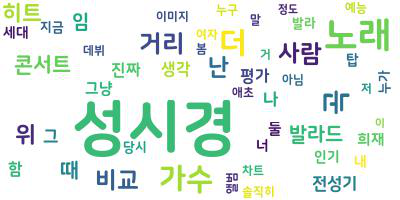

In [ ]:
from PIL import Image
Image.open("./outputs/D12_sung_wordcloud.jpg")

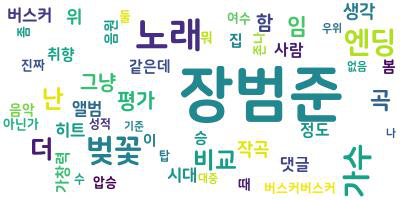

In [ ]:
Image.open("./outputs/D12_jang_wordcloud.jpg")

This is the end of this analysis. Thank you for reading!